The purpose of this notebook is to show on the one hand the use of the FHIR2datset module and on the other hand the underlying functionalities of this module.

# Notebook initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
txt = os.getcwd()
txt = txt.split("/")[:-1]
parent_path = "/".join(txt)
os.chdir(parent_path)
import logging
logging.basicConfig(filename="log.txt", level=logging.INFO)

In [3]:
# os.getcwd()

Necessary imports to use the module classically

In [4]:
from fhir2dataset import Query, FHIRRules, FHIR2DatasetParser

Additional imports to show the inner workings of the module

In [5]:
import json
import pprint
import pandas as pd
from IPython.display import Markdown as md
pp = pprint.PrettyPrinter(indent=1)

from fhir2dataset.graph_tools import join_path
from fhir2dataset.url_builder import URLBuilder
from fhir2dataset.visualization_tools import custom_repr
from fhir2dataset.data_class import show_tree

## Loading the example used for the tutorial

We will answer this question with the example stored in the following folder:

In [6]:
dirname = 'tests/5'

In [7]:
filename_config = 'config.json'
filename_question = 'question.md'
filename_sql_like_query = 'infos_test/sql_like_query.md'

with open(os.path.join(dirname, filename_config)) as json_file:
    config = json.load(json_file)
with open(os.path.join(dirname, filename_question), 'r') as mardown_file:
     question= mardown_file.read()
with open(os.path.join(dirname, filename_sql_like_query), 'r') as mardown_file:
    sql_like_query= mardown_file.read()

# What's this module for? 

The module will make it possible to answer the following question knowing that the searched data are stored in a database provided with an API compliant with the FHIR standard. The data corresponding to the query will be returned in a tabular format, ideal for data analysis.

In [8]:
md(question)

Get information on Condition, AllergyIntolerance, Patient and Practitioner resources that meet all of the following conditions:

* patients were born in 1970 (associated search parameter of the resource Patient : birthdate=1970)
* they've been diagnosed allergic to Cashew nuts (associated search parameter of the resource AllergyIntolerance: code=http://snomed.info/sct|227493005)
* the source of the information about the allergy is a practioner who lives in france (associated search parameter of the resource Practitioner: address-country=france)
* these patients have already had fever (associated search parameter of the resource Condition: code=http://snomed.info/sct|386661006)

If you are familiar with SQL queries, the kind of query you would have made would have been as follows:

Note: the queries that will be made by this module are not exact SQL queries, they are in a way more flexible to be integrated with other services thanks to the configuration file.

In [9]:
print(sql_like_query)

SELECT patient.Patient.name.family,patient.Patient.name.given,patient.Patient.birthDate,patient.Patient.id,practitioner.Practitioner.name.family,practitioner.Practitioner.address.use,practitioner.Practitioner.address.line,practitioner.Practitioner.address.city,practitioner.Practitioner.id,allergy.AllergyIntolerance.code.coding.display,allergy.AllergyIntolerance.id,condition.Condition.code.coding.display,condition.Condition.severity.coding.display,condition.Condition.id

FROM AllergyIntolerance AS allergy
INNER JOIN Patient AS patient ON allergy.patient = patient.id
INNER JOIN Practitioner AS practitioner ON allergy.asserter = practitioner.id
INNER JOIN Condition AS condition ON condition.subject = patient.id

WHERE patient.birthdate = "1976"
AND allergy.code = "http://snomed.info/sct|22749300"
AND practitioner.address-city = "paris"
AND condition.code = "http://snomed.info/sct|386661006"



# How to use this module?

### 1. First of all, the elements of the query you want to make must be translated into a json configuration file.

The configuration file for the example is therefore:

In [10]:
pp.pprint(config)

{'from': {'allergy': 'AllergyIntolerance',
          'condition': 'Condition',
          'patient': 'Patient',
          'practitioner': 'Practitioner'},
 'join': {'inner': {'allergy': {'asserter': 'practitioner',
                                'patient': 'patient'},
                    'condition': {'subject': 'patient'}}},
 'select': {'allergy': ['AllergyIntolerance.code.coding.display',
                        'AllergyIntolerance.id'],
            'condition': ['Condition.code.coding.display',
                          'Condition.severity.coding.display',
                          'Condition.id'],
            'patient': ['Patient.name.family',
                        'Patient.name.given',
                        'Patient.birthDate',
                        'Patient.id'],
            'practitioner': ['Practitioner.name.family',
                             'Practitioner.address.use',
                             'Practitioner.address.line',
                             'Practitioner

It is also possible to transform the SQL like query into a configuration file

In [11]:
parser = FHIR2DatasetParser()
config_from_parser = parser.parse(sql_like_query)
pp.pprint(config_from_parser)

{'from': {'allergy': 'AllergyIntolerance',
          'condition': 'Condition',
          'patient': 'Patient',
          'practitioner': 'Practitioner'},
 'join': {'inner': {'allergy': {'asserter': 'practitioner',
                                'patient': 'patient'},
                    'condition': {'subject': 'patient'}}},
 'select': {'patient': ['Patient.name.family,patient.Patient.name.given,patient.Patient.birthDate,patient.Patient.id,practitioner.Practitioner.name.family,practitioner.Practitioner.address.use,practitioner.Practitioner.address.line,practitioner.Practitioner.address.city,practitioner.Practitioner.id,allergy.AllergyIntolerance.code.coding.display,allergy.AllergyIntolerance.id,condition.Condition.code.coding.display,condition.Condition.severity.coding.display,condition.Condition.id']},
 'where': {'allergy': {'code': '"http://snomed.info/sct|22749300"'},
           'condition': {'code': '"http://snomed.info/sct|386661006"'},
           'patient': {'birthdate': '"1976"

In [12]:
# READ OUTPUT
alias = list(config['from'].keys())[0]
resource_type = config['from'][alias]
url_fhir_doc = f"https://www.hl7.org/fhir/{resource_type.lower()}.html"
md(
    f"a. The information contained in the **'from'** allows you to specify the **FHIR type of resource** "
    f"associated with each alias.<br><br>"
    f"For example, here the alias **{alias}** is a FHIR resource "
    f"of type **{resource_type}** whose corresponding documentation can be found at the following link: [{url_fhir_doc}]({url_fhir_doc})"
)

a. The information contained in the **'from'** allows you to specify the **FHIR type of resource** associated with each alias.<br><br>For example, here the alias **allergy** is a FHIR resource of type **AllergyIntolerance** whose corresponding documentation can be found at the following link: [https://www.hl7.org/fhir/allergyintolerance.html](https://www.hl7.org/fhir/allergyintolerance.html)

In [13]:
# READ OUTPUT
data = {
    'alias linked to a parent-type resource':
    {'search parameter leading to a Reference type data in the json of an occurrence of a FHIR resource of the parent type': 'alias linked to a child-type resource'}}

join_how=list(config['join'].keys())[0]
parent_alias = list(config['join'][join_how].keys())[0]
expression = list(config['join'][join_how][parent_alias].keys())[0]
child_alias = config['join'][join_how][parent_alias][expression]
data_example = { parent_alias: {expression: child_alias}}

url_fhir_doc=f"https://www.hl7.org/fhir/{parent_alias.lower()}.html#resource"
md(
    f"b. The information contained in the **'join'** allows you to specify "
    f"**how the aliases are linked together**.<br><br>"
    f"Joins are of the parent-child type, i.e. in a resource instance of the "
    f"parent type there is a [reference](https://www.hl7.org/fhir/references.html#Reference) to an instance of the child resource type. "
    f"This will result in the following structure in the configuration file:<br><br>"
    f"{data}<br><br>"
    f"Example ([FHIR doc associated]({url_fhir_doc})):<br>"
    f"{data_example}<br><br>"
    f"Note: each alias must at least be linked to another alias."
)

b. The information contained in the **'join'** allows you to specify **how the aliases are linked together**.<br><br>Joins are of the parent-child type, i.e. in a resource instance of the parent type there is a [reference](https://www.hl7.org/fhir/references.html#Reference) to an instance of the child resource type. This will result in the following structure in the configuration file:<br><br>{'alias linked to a parent-type resource': {'search parameter leading to a Reference type data in the json of an occurrence of a FHIR resource of the parent type': 'alias linked to a child-type resource'}}<br><br>Example ([FHIR doc associated](https://www.hl7.org/fhir/condition.html#resource)):<br>{'condition': {'subject': 'patient'}}<br><br>Note: each alias must at least be linked to another alias.

In [14]:
# READ OUTPUT
alias = list(config['where'].keys())[0]
url_fhir_doc=f"https://www.hl7.org/fhir/{alias.lower()}.html#search"

data = {
    'alias': {'search param': {'prefix': 'value'}}
}
data_default = {
    'alias': {'search param': 'value'}
}
md(
    f"c. The information contained in the **'where'** allows you to specify the **conditions "
    f"on the search parameters**.<br><br>"
    f"For example, the search parameters that the alias {alias} can have are specified "
    f"[here]({url_fhir_doc}) in the FHIR doc."
    f"This will result in the following structure in the configuration file:<br>"
    f"{data}<br><br>"
    f"The prefixes that can be used are those specified [here](https://www.hl7.org/fhir/search.html#prefix) in the FHIR doc."
    f"It is also possible to use a simplified structure that assumes that the prefix used is eq:<br>"
    f"{data_default}<br><br>"
)

c. The information contained in the **'where'** allows you to specify the **conditions on the search parameters**.<br><br>For example, the search parameters that the alias patient can have are specified [here](https://www.hl7.org/fhir/patient.html#search) in the FHIR doc.This will result in the following structure in the configuration file:<br>{'alias': {'search param': {'prefix': 'value'}}}<br><br>The prefixes that can be used are those specified [here](https://www.hl7.org/fhir/search.html#prefix) in the FHIR doc.It is also possible to use a simplified structure that assumes that the prefix used is eq:<br>{'alias': {'search param': 'value'}}<br><br>

In [15]:
# READ OUTPUT
alias = None
expressions = None
url_fhir_doc = None
resource = None
for key in config['select'].keys():
    if key != 'count':
        alias = key
        expressions = config['select'][key]
        resource = config['from'][key]
        url_fhir_doc = f"https://www.hl7.org/fhir/{resource.lower()}.html#resource"
        break
md(
    f"d. The information contained in the **'select'** allows you to specify the elements that "
    f"must be present in the output table.<br><br>"
    f"For example, for the instances corresponding to the alias {alias} it will be necessary to "
    f"retrieve the information in the JSON targeted by the search parameters and/or fhirpaths: {expressions}. "
    f"It can be observed that these search parameters and/or fhirpath correspond well to the FHIR specifications of "
    f"the associated [{resource} resource](url_fhir_doc).<br><br>"
    f"Since v0.2.0, it is recommanded to use fhirpath instead of search parameters. Indeed, the potential link between "
    f"2 columns is determined with the fhirpath of the 2 columns. By nature, the search parameter hide a fhirpath which "
    f"can lead to an unwanted resulting dataframe."
)

d. The information contained in the **'select'** allows you to specify the elements that must be present in the output table.<br><br>For example, for the instances corresponding to the alias patient it will be necessary to retrieve the information in the JSON targeted by the search parameters and/or fhirpaths: ['Patient.name.family', 'Patient.name.given', 'Patient.birthDate', 'Patient.id']. It can be observed that these search parameters and/or fhirpath correspond well to the FHIR specifications of the associated [Patient resource](url_fhir_doc).<br><br>Since v0.2.0, it is recommanded to use fhirpath instead of search parameters. Indeed, the potential link between 2 columns is determined with the fhirpath of the 2 columns. By nature, the search parameter hide a fhirpath which can lead to an unwanted resulting dataframe.

### 2. Initilize an instance of the **Query class**

3 things are needed to initialize this instance:
* fhir_api_url: the Service Base URL (e.g. [http://hapi.fhir.org/baseR4/](http://hapi.fhir.org/baseR4/))
* a FHIRRules instance containing information about the search parameters of the targeted FHIR API 
* config : a json file in the previously described format

In [16]:
fhir_api_url = 'http://hapi.fhir.org/baseR4/'

#fhir_rules can be instantiated only once and then used for all the querries
fhir_rules=FHIRRules(fhir_api_url=fhir_api_url)

In [17]:
query = Query(fhir_api_url,fhir_rules=fhir_rules)
query.from_config(config)

### 3. Request the execution of the query

In [18]:
query.execute()

#### What does this function do?

##### 3.1 Storing info from the config file in a graph

Below we can see a visualization of the relationships that have been established between the aliases.

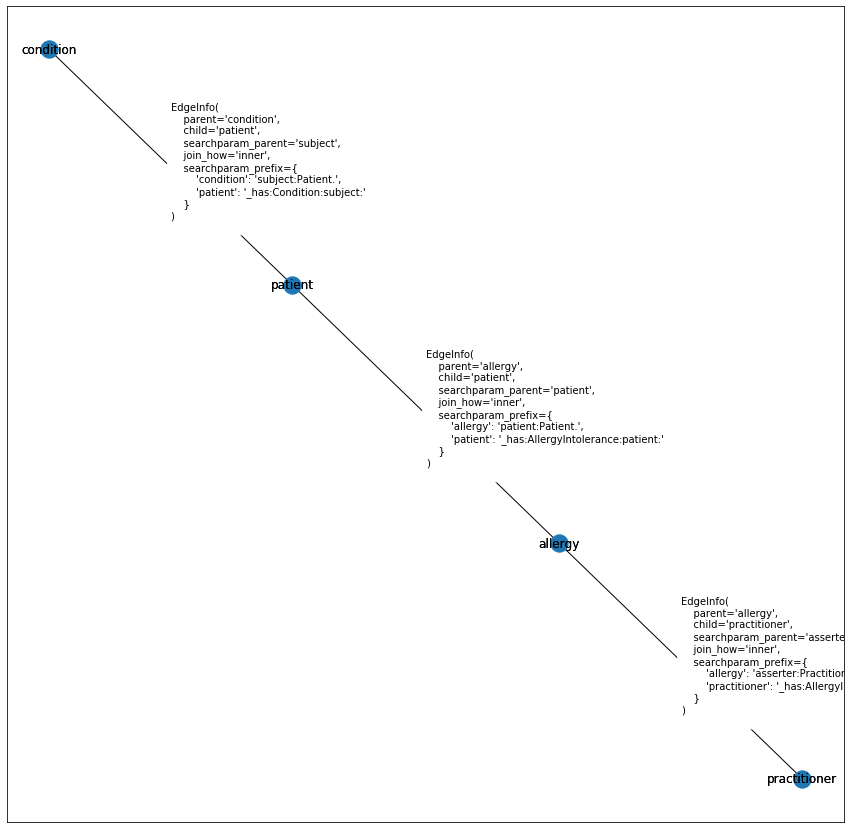

In [19]:
query.graph_query.draw_relations()

In [20]:
edge = list(query.graph_query.resources_alias_graph.edges)[0]
edge_info = query.graph_query.resources_alias_graph.edges[edge]["info"]

md(
    f"Each edge contains a lot of information. We will illustrate this by the content of the edge between **{edge[0]}** and **{edge[1]}**.<br>"
    f" - the alias of the **parent** resource: *{edge_info.parent}*<br>"
    f" - the alias of the **child** resource: *{edge_info.child}*<br>"
    f" - the **expression** in an instance of *{edge_info.parent}* resource-type which must indicate a reference identical to the id of *{edge_info.child}* resource-type: *{edge_info.searchparam_parent}*<br>"
    f" - the **prefix** that must be added **in front of a param search** in the url of a query sent to a FHIR API if the request is made from an *{edge_info.parent}* resource-type but the search parameter relates to a *{edge_info.child}* resource-type : "
    f"*{edge_info.searchparam_prefix[edge_info.parent]}*<br>"
    f" - also the reverse **prefix** from a *{edge_info.child}* resource-type to a *{edge_info.parent}* resource-type : "
    f"*{edge_info.searchparam_prefix[edge_info.child]}*<br>"
    "the other information is not useful for the moment"
)

Each edge contains a lot of information. We will illustrate this by the content of the edge between **allergy** and **patient**.<br> - the alias of the **parent** resource: *allergy*<br> - the alias of the **child** resource: *patient*<br> - the **expression** in an instance of *allergy* resource-type which must indicate a reference identical to the id of *patient* resource-type: *patient*<br> - the **prefix** that must be added **in front of a param search** in the url of a query sent to a FHIR API if the request is made from an *allergy* resource-type but the search parameter relates to a *patient* resource-type : *patient:Patient.*<br> - also the reverse **prefix** from a *patient* resource-type to a *allergy* resource-type : *_has:AllergyIntolerance:patient:*<br>the other information is not useful for the moment

Each node also contains several pieces of information. This information can be found in the dictionary: *query.graph_query.resources_alias_info*

In [21]:
maxi_len = 0
maxi_alias = None
maxi_elements = None
resource_type= None
for resource_alias, node_info in query.graph_query.resources_alias_info.items():
    curr_len = len(node_info.elements.elements)
    if curr_len > maxi_len:
        maxi_len = curr_len
        maxi_alias = resource_alias
        maxi_elements = node_info.elements
        resource_type = node_info.resource_type

elements_str = custom_repr(maxi_elements.__repr__(), breakline_char="<br>", indent_char="·").replace("[","\[").replace("]","\]")
md(
    f"For example, node *{maxi_alias}* contains the following information: <br>"
    f" - the **type of the associated resource**: *{resource_type}*<br>"
    f" - the **the elements** to be retrieved in the json format of the instances corresponding to the query: {elements_str}<br>"
    f" - the **forest of process trees** which shows the sequence of operations that must be performed on a resource of type *{resource_type}* to retrieve the elements listed above. The position of an item in the list above allows you to find it in the forest below."
)

For example, node *practitioner* contains the following information: <br> - the **type of the associated resource**: *Practitioner*<br> - the **the elements** to be retrieved in the json format of the instances corresponding to the query: Elements(<br>····elements=\[<br>········Element(<br>············col_name='from_id',<br>··········· fhirpath='id',<br>··········· goal='additional_resource',<br>··········· value=\[<br>················'pp4'<br>············\],<br>··········· concat_type='row',<br>··········· search_parameter=None<br>········),<br>······· Element(<br>············col_name='where_address-city',<br>··········· fhirpath='Patient.address.city | Person.address.city | Practitioner.address.city | RelatedPerson.address.city',<br>··········· goal='where',<br>··········· value=\[<br>················'Paris'<br>············\],<br>··········· concat_type='cell',<br>··········· search_parameter=SearchParameter(<br>················code='address-city',<br>··············· fhirpath=None,<br>··············· resource_types=None,<br>··············· prefix=None,<br>··············· value='paris'<br>············)<br>········),<br>······· Element(<br>············col_name='Practitioner.name.family',<br>··········· fhirpath='Practitioner.name.family',<br>··········· goal='select',<br>··········· value=\[<br>················\[<br>····················'Careful'<br>················\]<br>············\],<br>··········· concat_type='cell',<br>··········· search_parameter=None<br>········),<br>······· Element(<br>············col_name='Practitioner.address.use',<br>··········· fhirpath='Practitioner.address.use',<br>··········· goal='select',<br>··········· value=\[<br>················\[<br>····················\[<br>························'home'<br>····················\]<br>················\]<br>············\],<br>··········· concat_type='cell',<br>··········· search_parameter=None<br>········),<br>······· Element(<br>············col_name='Practitioner.address.line',<br>··········· fhirpath='Practitioner.address.line',<br>··········· goal='select',<br>··········· value=\[<br>················\[<br>····················\[<br>························'1 blv st michel'<br>····················\]<br>················\]<br>············\],<br>··········· concat_type='cell',<br>··········· search_parameter=None<br>········),<br>······· Element(<br>············col_name='Practitioner.address.city',<br>··········· fhirpath='Practitioner.address.city',<br>··········· goal='select',<br>··········· value=\[<br>················\[<br>····················\[<br>························'Paris'<br>····················\]<br>················\]<br>············\],<br>··········· concat_type='cell',<br>··········· search_parameter=None<br>········),<br>······· Element(<br>············col_name='Practitioner.id',<br>··········· fhirpath='Practitioner.id',<br>··········· goal='select',<br>··········· value=\[<br>················\[<br>····················'pp4'<br>················\]<br>············\],<br>··········· concat_type='cell',<br>··········· search_parameter=None<br>········)<br>····\]<br>)<br><br> - the **forest of process trees** which shows the sequence of operations that must be performed on a resource of type *Practitioner* to retrieve the elements listed above. The position of an item in the list above allows you to find it in the forest below.

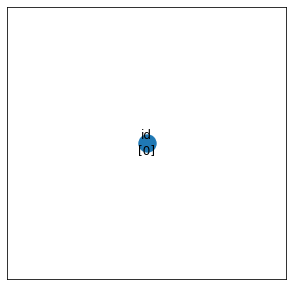

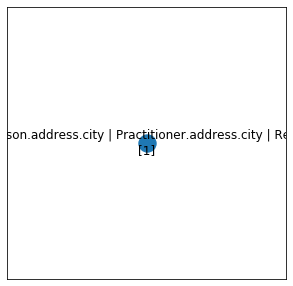

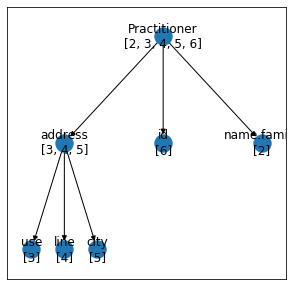

In [22]:
for tree in maxi_elements.forest.trees.values():
    show_tree(tree.graph)

##### 3.2 Making calls to the api for each node of the graph

In [23]:
print(f"The url queries that are made for each nodes are:")
for resource_alias in query.graph_query.resources_alias_info.keys():
    url_builder = URLBuilder(
                    fhir_api_url=fhir_api_url,
                    graph_query=query.graph_query,
                    main_resource_alias=resource_alias,
                )
    print(f" - {resource_alias} → {url_builder.compute()}")

The url queries that are made for each nodes are:
 - allergy → http://hapi.fhir.org/baseR4/AllergyIntolerance?patient%3APatient.birthdate=1976&asserter%3APractitioner.address-city=paris&code=http%3A%2F%2Fsnomed.info%2Fsct%7C22749300
 - patient → http://hapi.fhir.org/baseR4/Patient?_has%3ACondition%3Asubject%3Acode=http%3A%2F%2Fsnomed.info%2Fsct%7C386661006&_has%3AAllergyIntolerance%3Apatient%3Acode=http%3A%2F%2Fsnomed.info%2Fsct%7C22749300&birthdate=1976
 - practitioner → http://hapi.fhir.org/baseR4/Practitioner?_has%3AAllergyIntolerance%3Aasserter%3Acode=http%3A%2F%2Fsnomed.info%2Fsct%7C22749300&address-city=paris
 - condition → http://hapi.fhir.org/baseR4/Condition?subject%3APatient.birthdate=1976&code=http%3A%2F%2Fsnomed.info%2Fsct%7C386661006


##### 3.3 Storing query results in multiple dataframes (1 dataframe per alias)

In [24]:
for _,df in query.dataframes.items():
    display(df.head(5))

,allergy:from_id,allergy:join_patient,allergy:join_asserter,allergy:where_code,allergy:AllergyIntolerance.code.coding.display,allergy:AllergyIntolerance.id
0,AllergyIntolerance/frt4,Patient/frt2,Practitioner/frt1,[the fhirpath could not be evaluated by the li...,[[Cashew nuts]],[[frt4]]
0,AllergyIntolerance/al9,Patient/i3,Practitioner/pp4,[the fhirpath could not be evaluated by the li...,[[Cashew nuts]],[[al9]]


,patient:from_id,patient:where_birthdate,patient:Patient.name.family,patient:Patient.name.given,patient:Patient.birthDate,patient:Patient.id
0,Patient/frt2,[1976-01-01],"[[[Smith], [Smth]]]","[[[Darcy], [DD, Mme D.]]]",[[1976-01-01]],[[frt2]]
0,Patient/i3,[1976-01-01],[[[Green]]],[[[Darcy]]],[[1976-01-01]],[[i3]]


,practitioner:from_id,practitioner:where_address-city,practitioner:Practitioner.name.family,practitioner:Practitioner.address.use,practitioner:Practitioner.address.line,practitioner:Practitioner.address.city,practitioner:Practitioner.id
0,Practitioner/frt1,"[Paris, NY]",[[Careful]],"[[[home], [work]]]","[[[1 blv st michel], [1 street Georges]]]","[[[Paris], [NY]]]",[[frt1]]
0,Practitioner/pp4,[Paris],[[Careful]],[[[home]]],[[[1 blv st michel]]],[[[Paris]]],[[pp4]]


,condition:from_id,condition:join_subject,condition:where_code,condition:Condition.code.coding.display,condition:Condition.severity.coding.display,condition:Condition.id
0,Condition/f105f80c-52d6-4e21-886b-9ec46d332307,Patient/30dcdb89-e6be-4fed-810b-43ef0d9db8f8,[the fhirpath could not be evaluated by the li...,[[Fever (finding)]],[[None]],[[f105f80c-52d6-4e21-886b-9ec46d332307]]
0,Condition/frt3,Patient/frt2,[the fhirpath could not be evaluated by the li...,[[Cashew nuts]],[[Mild]],[[frt3]]
0,Condition/cc7,Patient/i3,[the fhirpath could not be evaluated by the li...,[[Cashew nuts]],[[Mild]],[[cc7]]


##### 3.4 Joining the dataframes by following an eulerian path in the graph

The dataframes of each alias will be linked in the following order.
This order corresponds to a Eulerian path in the query graph and thus guarantees that joins between the main dataframe (left alias) and the new dataframe (right alias) will be possible.

In [25]:
pp.pprint(join_path(query.graph_query.resources_alias_graph))

[('allergy', 'practitioner'), ('allergy', 'patient'), ('patient', 'condition')]



### Display the result of the query

In [26]:
df = query.main_dataframe
df

,allergy:AllergyIntolerance.code.coding.display,allergy:AllergyIntolerance.id,patient:Patient.name.family,patient:Patient.name.given,patient:Patient.birthDate,patient:Patient.id,practitioner:Practitioner.name.family,practitioner:Practitioner.address.use,practitioner:Practitioner.address.line,practitioner:Practitioner.address.city,practitioner:Practitioner.id,condition:Condition.code.coding.display,condition:Condition.severity.coding.display,condition:Condition.id
0,[Cashew nuts],[frt4],"[[Smith], [Smth]]","[[Darcy], [DD, Mme D.]]",[1976-01-01],[frt2],[Careful],"[[home], [work]]","[[1 blv st michel], [1 street Georges]]","[[Paris], [NY]]",[frt1],[Cashew nuts],[Mild],[frt3]
1,[Cashew nuts],[al9],[[Green]],[[Darcy]],[1976-01-01],[i3],[Careful],[[home]],[[1 blv st michel]],[[Paris]],[pp4],[Cashew nuts],[Mild],[cc7]


# Save a lighter version of this notebook

In the terminal run:
```
jupyter nbconvert tutorials_generator.ipynb --TagRemovePreprocessor.remove_input_tags='{"hide"}'
```